In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD,
  TERMS_OF_PAYMENT_KEY  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df

,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY
0,2057199296,,,0000041400,2057199296,2023-08-24,ZF,01 - Invoice,11.130000000,PD,CLEAR,2007-12-13,5.000000000,YS05
1,2057199296,,,0000041400,2057199296,2023-08-25,ZF,01 - Invoice,12115.260000000,PD,CLEAR,2007-12-13,5.000000000,YS05
2,2057199296,,,0000041400,2057199296,2023-08-23,ZF,11 - Credit memo,-10.130000000,PD,CLEAR,2007-12-13,0E-9,YS05
3,2057199296,,,0000041400,2057199296,2023-08-21,ZF,01 - Invoice,474.830000000,PD,CLEAR,2007-12-13,5.000000000,YS05
4,2057199296,,,0000041400,2057199296,2023-08-23,ZF,01 - Invoice,25.280000000,PD,CLEAR,2007-12-13,5.000000000,YS05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50678254,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2023-12-22,DH,07 - Other clearing,14319.260000000,Z2140,CLEAR,2023-12-22,0E-9,Y020
50678255,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2021-12-21,DH,16 - Payment difference,-246.170000000,Z2140,CLEAR,2023-12-22,0E-9,
50678256,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2022-04-27,DH,16 - Payment difference,-121.890000000,Z2140,CLEAR,2023-12-22,0E-9,
50678257,0011139510,7100000255,7100000255 - ADVENTIST HEALTH,,None,2023-12-22,DH,17 - Other clearing,-42184.980000000,Z2140,CLEAR,2023-12-22,0E-9,


In [7]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
# df['CC_DAYS_TO_ADD']=df['CC_DAYS_TO_ADD'].apply(lambda x: float(x))
# df['AMOUNT_IN_LOCAL_CURRENCY']=df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
# df.reset_index(inplace = True)


In [ ]:
def calc_WAPD1(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
            WAPD_new[index]=0
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [8]:
def calc_WAPD(df_1):
    try:
        df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
        df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
        # WAPD_new = pd.Series([])
        start_date= df_1['PAYMENT_DATE']
        end_date = df_1['90_days_ago']
        ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
        # print(ninety_day_range)
        df_1['WAPD']= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
    except:
        print('no PAYMENT_DATE')
    
    return df_1

In [77]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    
    CUSTOMER_df.reset_index(inplace = True)
    # print(CUSTOMER_df)
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    CUSTOMER_df = final_dataFram(CUSTOMER_df)
    return CUSTOMER_df

In [10]:
# Returns a tuple of DataFrames sorted by DSO term

def get_terms(ENTERPRISE_ACCOUNT_NO):
    return_list = []
    
    terms_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    
    # terms_df.reset_index(inplace = True)
    terms_list = terms_df['CC_DAYS_TO_ADD'].unique()
    print(terms_list)
    
    # for dso_term in terms_list:
    #     name = str(dso_term)+"_term"
    #     name = terms_df.query('CC_DAYS_TO_ADD ==@dso_term')
    #     return_list.append(name)
    
    return None
 



In [65]:
def search_EAN(term,EAN):
    print(term)
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @EAN')
    CUSTOMER_df=CUSTOMER_df.query('CC_DAYS_TO_ADD == @term')
    CUSTOMER_df.reset_index(inplace = True)
   
    # CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    
    
    
    return CUSTOMER_df

In [12]:
def final_dataFram(toFix_df):
    toFix_df['month'] = toFix_df['PAYMENT_DATE'].dt.strftime('%b')
    df_final = pd.DataFrame({'Year': toFix_df.PAYMENT_DATE.dt.year,
                   'Month': toFix_df.month,
                   'CREDIT_CONTROL_AREA': toFix_df.CREDIT_CONTROL_AREA,
                   'WAPD':toFix_df.WAPD,
                    "CC_DAYS_TO_ADD":toFix_df.CC_DAYS_TO_ADD})
    dfff = (
        df_final
        .filter(["Year", "Month","CREDIT_CONTROL_AREA","WAPD","CC_DAYS_TO_ADD"])
        .groupby(['Year','Month','CREDIT_CONTROL_AREA',"CC_DAYS_TO_ADD"])
        .agg({'WAPD' : ['mean']})
        .sort_values(['Year',"Month","CC_DAYS_TO_ADD"])
        .reset_index()
    )
    dfff.columns = ['Year','Month', 'CREDIT_CONTROL_AREA','CC_DAYS_TO_ADD',"WAPD"]
    get_graph(dfff)
    return dfff
    

In [74]:
def get_graph(finished_df):
    dff = pd.DataFrame(
        dict(
            year=finished_df.Year.values ,
            month=finished_df.Month.values,
            CCA= finished_df.CREDIT_CONTROL_AREA.values,
            WAPD=finished_df.WAPD.values,
            dso_term = finished_df.CC_DAYS_TO_ADD.values
        )
    )

    fig = go.Figure()
    # fig = make_subplots(1,1)

    fig.update_layout(
        template="none",
        xaxis=dict(title_text="Year"),
        yaxis=dict(title_text="WAPD"),
        barmode="group",
    )

    colors = ["#456e73","#2A66DE", "#FFC32B","#457353"]

    for r, c in zip(dff.CCA.unique(), colors):
        plot_df = dff[dff.CCA == r]
        fig.add_trace(go.Bar(x=[plot_df.year, plot_df.month], y=plot_df.WAPD, name="DSO Term = "+str(r), marker_color=c))


    fig.add_trace(go.Scatter(x= [dff.year, dff.month], y=dff.dso_term, mode = 'lines',name = "DSO Term"))


    # fig.plot(fi.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
    fig.update_layout(title='WAPD')
    fig.show()

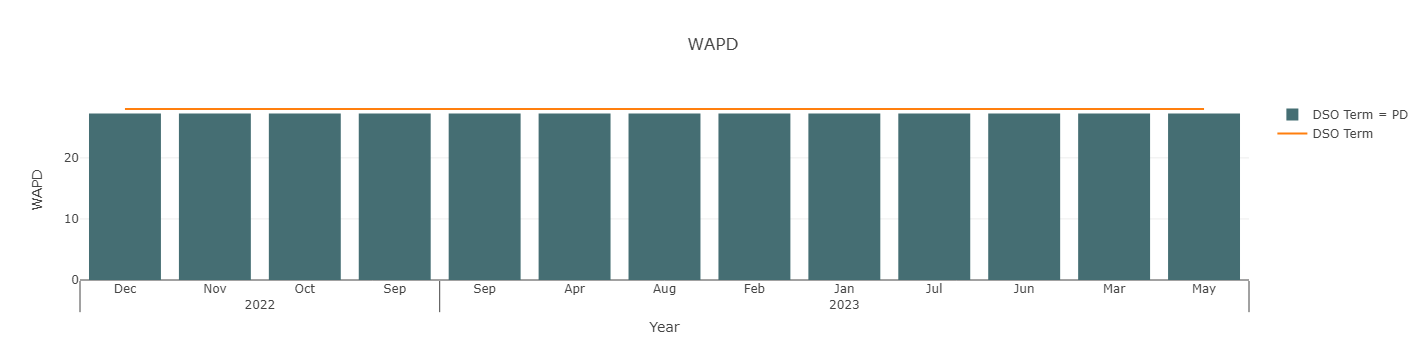

In [78]:
customer = "2057194397"
t = search_customer(customer)

# **********************************************************************************************************

# Visualization

## Customer

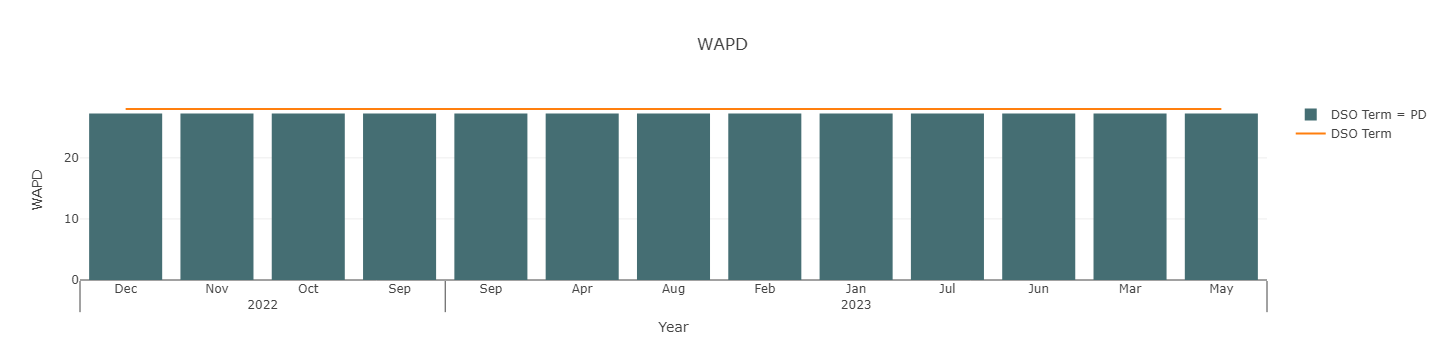

In [79]:
customer = "2057194397"
t = search_customer(customer)

In [80]:
t

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2022,Dec,PD,28.000000000,27.2561
1,2022,Nov,PD,28.000000000,27.2561
2,2022,Oct,PD,28.000000000,27.2561
3,2022,Sep,PD,28.000000000,27.2561
4,2023,Apr,PD,28.000000000,27.2561
5,2023,Aug,PD,28.000000000,27.2561
6,2023,Feb,PD,28.000000000,27.2561
7,2023,Jan,PD,28.000000000,27.2561
8,2023,Jul,PD,28.000000000,27.2561
9,2023,Jun,PD,28.000000000,27.2561


In [ ]:
fail

## EAN

In [57]:
EAN = "7100000656"
get_terms(EAN)
# DSO terms are printed below

[Decimal('7.000000000') Decimal('60.000000000') Decimal('15.000000000')
 Decimal('10.000000000') Decimal('30.000000000')]


In [63]:
term = 10

In [69]:
ten=search_EAN(term,EAN)

10


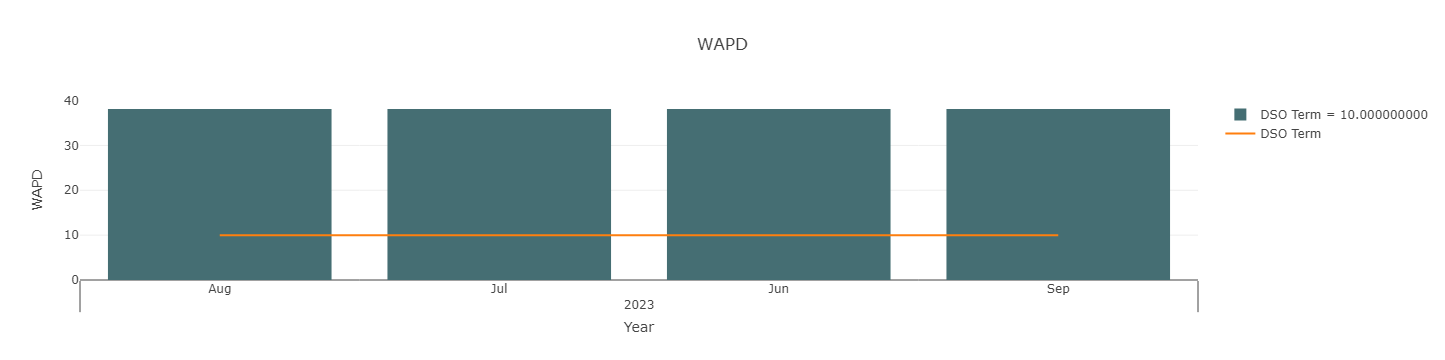

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2023,Aug,PD,10.000000000,38.1183
1,2023,Jul,PD,10.000000000,38.1183
2,2023,Jun,PD,10.000000000,38.1183
3,2023,Sep,PD,10.000000000,38.1183


In [70]:
final_dataFram(ten)

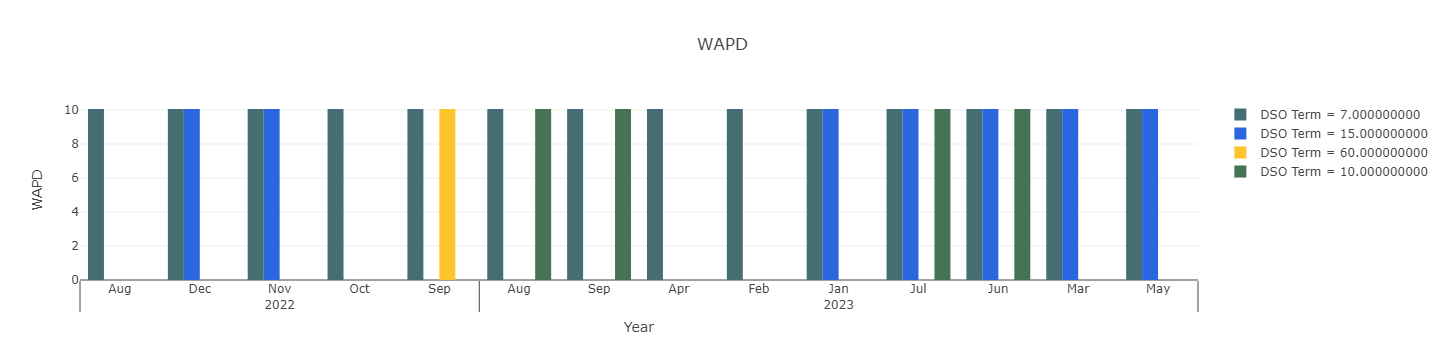

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2022,Aug,PD,7.000000000,10.0592
1,2022,Dec,PD,7.000000000,10.0592
2,2022,Dec,PD,15.000000000,10.0592
3,2022,Nov,PD,7.000000000,10.0592
4,2022,Nov,PD,15.000000000,10.0592
5,2022,Oct,PD,7.000000000,10.0592
6,2022,Sep,PD,7.000000000,10.0592
7,2022,Sep,PD,60.000000000,10.0592
8,2023,Apr,PD,7.000000000,10.0592
9,2023,Aug,PD,7.000000000,10.0592


In [60]:
final_dataFram(fi)


7


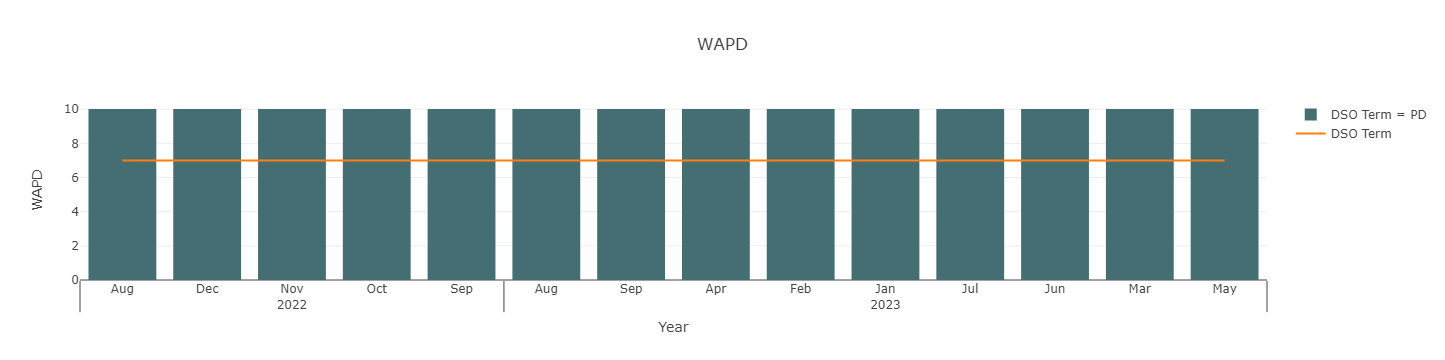

,Year,Month,CREDIT_CONTROL_AREA,CC_DAYS_TO_ADD,WAPD
0,2022,Aug,PD,7.000000000,10.0124
1,2022,Dec,PD,7.000000000,10.0124
2,2022,Nov,PD,7.000000000,10.0124
3,2022,Oct,PD,7.000000000,10.0124
4,2022,Sep,PD,7.000000000,10.0124
5,2023,Apr,PD,7.000000000,10.0124
6,2023,Aug,PD,7.000000000,10.0124
7,2023,Feb,PD,7.000000000,10.0124
8,2023,Jan,PD,7.000000000,10.0124
9,2023,Jul,PD,7.000000000,10.0124


In [75]:
term = 7
sixty=search_EAN(term,EAN)
final_dataFram(sixty)

## National Account

In [44]:
df.query("ENTERPRISE_ACCOUNT_NO == '7100000656'").CC_DAYS_TO_ADD.unique()

array([Decimal('7.000000000'), Decimal('60.000000000'),
       Decimal('15.000000000'), Decimal('10.000000000'),
       Decimal('30.000000000')], dtype=object)

In [41]:
df.ENTERPRISE_ACCOUNT_NO.value_counts().head(20)

7100007382    11373369
               7270425
7100017882     2932168
7100002977     2778541
7100000361     1279355
7100004101      774295
7100019180      605728
7100000001      336828
7100018765      232541
7100000212      230141
7100000110      216146
7100000344      200803
7100004141      193366
7100000121      190619
7100000381      146337
7100000329      140846
7100000356      134122
7100000165      118076
7100000348      111605
7100000656      104146
Name: ENTERPRISE_ACCOUNT_NO, dtype: int64